# Klassifikation von Rot- und Weißwein mit Keras
In diesem Notebook führen wir die vollständige Datenaufbereitung, Modellierung, Visualisierung und Evaluierung eines neuronalen Netzes zur Unterscheidung von Rot- und Weißwein durch.

In [1]:
import pandas as pd
import numpy as np
import keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2025-08-12 12:53:47.840537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 12:53:47.843855: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-12 12:53:47.853788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754996027.871344  233877 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754996027.876628  233877 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754996027.890491  233877 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Einlesen der Weindaten
Die CSV-Dateien befinden sich im Unterordner `data/processed`. Sie enthalten standardisierte chemische Merkmale für Rot- und Weißweine.

In [2]:
white = pd.read_csv('../data/processed/winequality-white.csv', sep=';')
red = pd.read_csv('../data/processed/winequality-red.csv', sep=';')

## Labeln und Zusammenführen der Datensätze
Für supervised learning bönitgen wir labels:
- Rotwein erhält das Label `1`
- Weißwein das Label `0`

Danach werden die Daten zusammengeführt.

In [3]:
red['label'] = 1
white['label'] = 0
wines = pd.concat([red, white], ignore_index=True)

## Feature-Matrix und Zielvariable erzeugen
Die ersten 11 Spalten (chemische Eigenschaften) dienen als Input-Variablen
(Features). Die Zielvariable `y` ist das binäre Label (1 = Rotwein, 0 = Weißwein),
und wird in 1D-Array umgewandelt.

In [4]:
x = wines.iloc[:, 0:11]
y = np.ravel(wines['label'])

## Aufteilung in Trainings- und Testdaten
Der Datensatz wird im Verhältnis 70:30 in Trainings- und Testdaten aufgeteilt
(70% Trainingsdaten).

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.3, random_state = 42)

## Skalierung der Merkmale
Die Daten werden mit dem `StandardScaler` auf Mittelwert 0 und Standardabweichung
 1 standardisiert. Unterschiedliche Skalen der Inputvariablen (z. B. pH vs.
 Alkohol) können das Training stören. Der Fit erfolgt
 **nur auf dem Trainingsset, aber: Testdaten müssen auch transformiert werden**.

In [6]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Klassifikation von Weinen (rot vs. weiß) als binäres Klassifikationsproblem

Ziel: Vorhersage d. binären Labels (0 = rot, 1 = weiß) anhand chemischer
Eigenschaften

Das neuronale Netz wird an diese Problemstruktur angepasst:
- ein einzelnes Ausgabeneuron mit Sigmoid-Aktivierung (für binäre Klassifikation)
- Eingabedimension entspricht der Anzahl der Input-Features (hier: 11)


## Aufbau des neuronalen Netzes

Wir definieren ein sequentielles Keras-Modell, , in dem Layer nacheinander
hinzugefügt werden. Hyperparameter wie Anzahl der Hidden-Layer, Neuronenanzahl,
Aktivierungsfunktionen etc. sind frei wählbar. Die Sturktur ist wie folgt:
- Eingabeschicht: 12 Neuronen, ReLU, `input_dim=11`
- Hidden Layer: 8 Neuronen, ReLU
- Ausgabeschicht: 1 Neuron, Sigmoid (für binäre Klassifikation)

In [7]:
import keras as K  # oder: from tensorflow import keras as K

model = K.Sequential([
    K.layers.Input(shape=(11,)),          # <<— Input-Layer
    K.layers.Dense(12, activation='relu'),
    K.layers.Dense(8,  activation='relu'),
    K.layers.Dense(1,  activation='sigmoid')
])
# So wurde es SB 03 gemacht, aber veraltet ...
# model = K.models.Sequential()
# model.add(K.layers.Dense(units=12, activation='relu', input_dim=11))
# model.add(K.layers.Dense(units=8, activation='relu'))
# model.add(K.layers.Dense(units=1, activation='sigmoid'))

2025-08-12 12:53:50.806738: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Weitere Hintergründe

1. Erstellen eines sequenziellen Keras-Modells
2. Erste Schicht (Input-Layer + erste Dense-Schicht)
    + 12 Neuronen als Startwert (guter Richtwert, entspricht etwa der Feature-Anzahl)
    + Aktivierungsfunktion: ReLU (Standard bei Hidden-Layern)
    + input_dim: 11, da 11 Input-Features (chemische Eigenschaften)
3. Zweite Schicht (Hidden-Layer)
    + 8 Neuronen (leichte Reduktion gegenüber erster Schicht)
    + erneut ReLU-Aktivierung
4. Ausgabeschicht für binäre Klassifikation
    + 1 Neuron (0 = rot, 1 = weiß)
    + Aktivierungsfunktion: Sigmoid (liefert Werte zwischen 0 und 1 geeignet für
     binäre Klassen)
5. Für mehrklassige Klassifikation würde man stattdessen:
    + mehrere Ausgabeneuronen (entsprechend der Klassenzahl)
    + und eine 'softmax'-Aktivierung verwenden

## Kompilierung des Modells

Festlegen von Optimierer, Verlustfunktion und Metriken

- Optimierer: `Adam` (state-of-the-art für viele Probleme, adaptiv)
- Verlustfunktion: `binary_crossentropy` (geeignet für binäre Klassifikation)
- Metrik: `accuracy` (Anteil korrekt klassifizierter Beispiele pro Epoche)

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Modelltraining
Wir trainieren das Modell 20 Epochen lang mit `validation_split=0.3`.

In [9]:
hist = model.fit(x_train, y_train, epochs = 20, validation_split = 0.3)

Epoch 1/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1:22 831ms/step - accuracy: 0.5000 - loss: 0.7245

 45/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5195 - loss: 0.6870    

 92/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6040 - loss: 0.6310

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6171 - loss: 0.6217 - val_accuracy: 0.9392 - val_loss: 0.3609


Epoch 2/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.3112

 42/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9552 - loss: 0.3214 

 83/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9600 - loss: 0.3032

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - loss: 0.2940 - val_accuracy: 0.9817 - val_loss: 0.1418


Epoch 3/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0992

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9896 - loss: 0.1150 

 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9901 - loss: 0.1068

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.1045 - val_accuracy: 0.9912 - val_loss: 0.0649


Epoch 4/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0432

 43/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9942 - loss: 0.0559 

 82/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9939 - loss: 0.0528

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0522 - val_accuracy: 0.9934 - val_loss: 0.0460


Epoch 5/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0196

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9893 - loss: 0.0402 

 88/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9905 - loss: 0.0394

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0389 - val_accuracy: 0.9934 - val_loss: 0.0385


Epoch 6/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0180

 48/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9938 - loss: 0.0326 

 86/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9936 - loss: 0.0335

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0334 - val_accuracy: 0.9934 - val_loss: 0.0348


Epoch 7/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0094

 48/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9959 - loss: 0.0189 

 92/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9953 - loss: 0.0211

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0217 - val_accuracy: 0.9949 - val_loss: 0.0321


Epoch 8/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0109

 48/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9906 - loss: 0.0419 

 90/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9920 - loss: 0.0366

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0357 - val_accuracy: 0.9941 - val_loss: 0.0312


Epoch 9/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9688 - loss: 0.0598

 50/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9926 - loss: 0.0229 

 92/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9936 - loss: 0.0242

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0244 - val_accuracy: 0.9956 - val_loss: 0.0302


Epoch 10/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0095

 48/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9978 - loss: 0.0197 

 96/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9966 - loss: 0.0237

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0237 - val_accuracy: 0.9956 - val_loss: 0.0295


Epoch 11/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9375 - loss: 0.1725

 49/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9904 - loss: 0.0389 

 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9928 - loss: 0.0325

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0322 - val_accuracy: 0.9956 - val_loss: 0.0288


Epoch 12/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9688 - loss: 0.0306

 40/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9922 - loss: 0.0227 

 78/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9935 - loss: 0.0238

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0239 - val_accuracy: 0.9956 - val_loss: 0.0286


Epoch 13/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0039

 48/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9958 - loss: 0.0210 

 95/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9957 - loss: 0.0219

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0219 - val_accuracy: 0.9949 - val_loss: 0.0281


Epoch 14/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0067

 47/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9969 - loss: 0.0194 

 89/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9964 - loss: 0.0208

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0209 - val_accuracy: 0.9934 - val_loss: 0.0278


Epoch 15/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0011

 48/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9972 - loss: 0.0207 

 94/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9971 - loss: 0.0196

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0196 - val_accuracy: 0.9927 - val_loss: 0.0275


Epoch 16/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9688 - loss: 0.0475

 47/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9945 - loss: 0.0173 

 91/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9954 - loss: 0.0178

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0181 - val_accuracy: 0.9934 - val_loss: 0.0269


Epoch 17/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0073

 46/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9958 - loss: 0.0206 

 78/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9961 - loss: 0.0193

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0190 - val_accuracy: 0.9934 - val_loss: 0.0267


Epoch 18/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0017

 47/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9983 - loss: 0.0136 

 87/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9980 - loss: 0.0148

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0155 - val_accuracy: 0.9934 - val_loss: 0.0264


Epoch 19/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0030

 33/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0116 

 67/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0143

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0148 - val_accuracy: 0.9934 - val_loss: 0.0262


Epoch 20/20


  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0030

 48/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9957 - loss: 0.0232 

 94/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9962 - loss: 0.0207

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0205 - val_accuracy: 0.9934 - val_loss: 0.0261


- `x_train`, `y_train` sind die vorbereiteten Trainingsdaten
- `epochs = 20`: 20 Trainingsdurchläufe (kann bei Bedarf erhöht werden)
- `validation_split = 0.3`: 30% der Trainingsdaten werden zur Validierung abgezweigt
- **Achtung:** dies betrifft nur `x_train`/`y_train`, nicht die vorab separat
gehaltenen Testdaten!

## Verlauf der Genauigkeit während des Trainings
Die Trainings- und Validierungsgenauigkeit werden für jede Epoche geplottet.

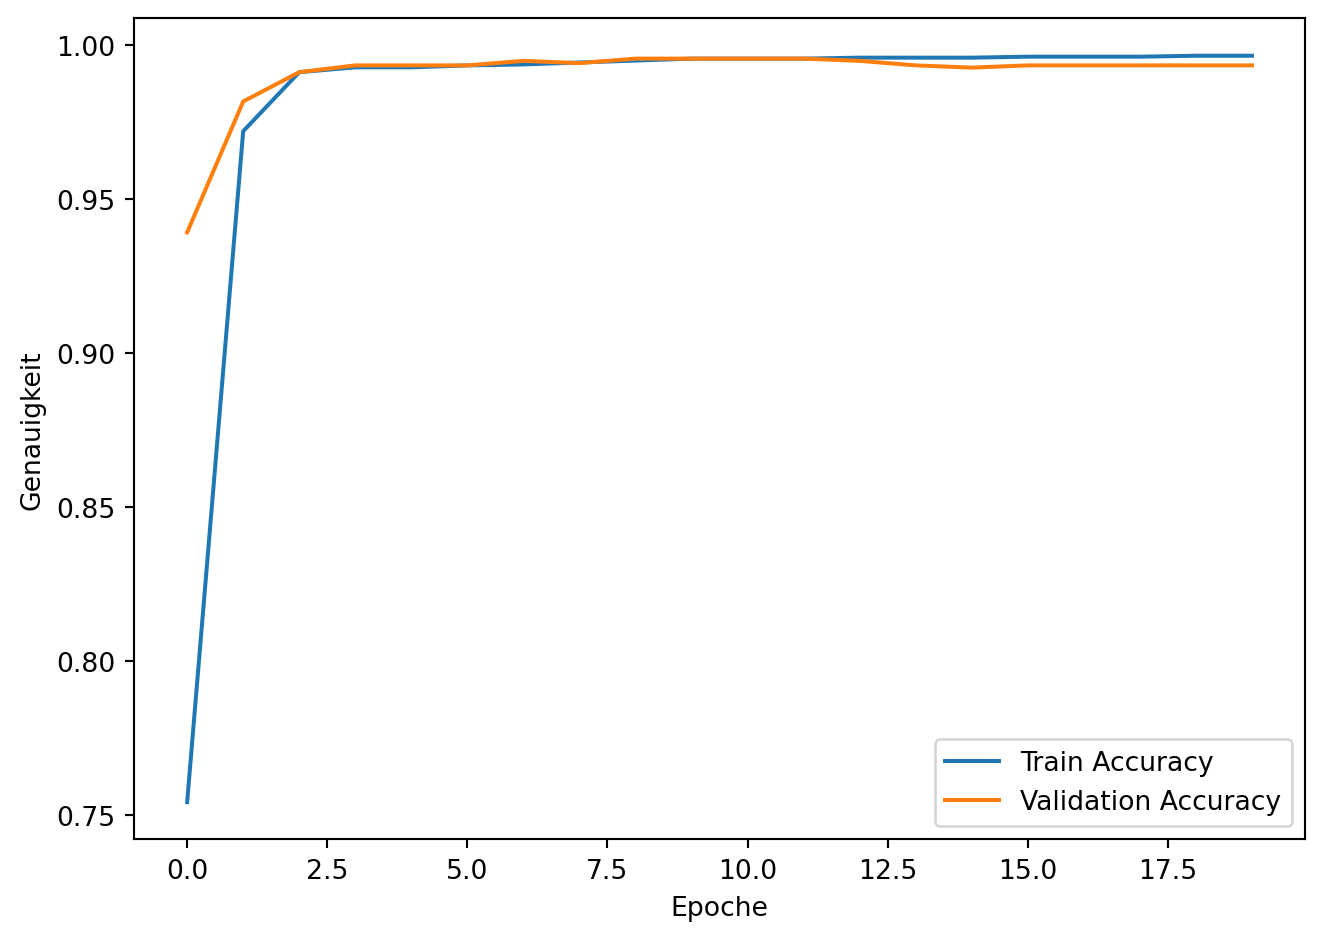

<Figure size 672x480 with 0 Axes>

In [10]:
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('../figs/training_accuracy.png')

## Evaluation auf Testdaten
Nach dem Training evaluieren wir das Modell auf der echten Testmenge und geben die Loss- und Accuracy-Werte aus.

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Testverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_acc:.4f}")

 1/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0312

54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.9952 - loss: 0.0297

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9950 - loss: 0.0302  


Testverlust: 0.0354
Testgenauigkeit: 0.9938


**Hinweis:**
- Die Validierung während des Trainings basiert auf `validation_split`
- Die finale Testgenauigkeit stammt aus einer separaten, vorher unberührten Testmenge
- Dadurch erhalten wir eine realistische Einschätzung der Generalisierungsfähigkeit